In [46]:
import random
from typing import List, Tuple

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import warnings

# Suppress specific warnings from ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [116]:
def detect_key(chroma_vals: np.ndarray) -> Tuple[str, str]:
    """Detect the key and mode (major or minor) of the audio segment."""
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    major_profile /= np.linalg.norm(major_profile)
    minor_profile /= np.linalg.norm(minor_profile)
    major_correlations = [np.corrcoef(chroma_vals, np.roll(major_profile, i))[0, 1] for i in range(12)]
    minor_correlations = [np.corrcoef(chroma_vals, np.roll(minor_profile, i))[0, 1] for i in range(12)]
    max_major_idx = np.argmax(major_correlations)
    max_minor_idx = np.argmax(minor_correlations)
    mode = 'major' if major_correlations[max_major_idx] > minor_correlations[max_minor_idx] else 'minor'
    key = note_names[max_major_idx if mode == 'major' else max_minor_idx]
    return key, mode

def calculate_ki_chroma(waveform: np.ndarray, sr: int, hop_length: int) -> np.ndarray:
    """Calculate a normalized, key-invariant chromagram for the given audio waveform."""
    chromagram = librosa.feature.chroma_cqt(y=waveform, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())
    chroma_vals = np.sum(chromagram, axis=1)
    key, mode = detect_key(chroma_vals)
    key_idx = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'].index(key)
    shift_amount = -key_idx if mode == 'major' else -(key_idx + 3) % 12
    return librosa.util.normalize(np.roll(chromagram, shift_amount, axis=0), axis=1)

def calculate_rms_energy(y: np.ndarray, hop_length: int) -> np.ndarray:
    """Calculate the RMS energy for each frame of the given audio waveform."""
    S, _ = librosa.magphase(librosa.stft(y, hop_length=hop_length))
    rms = librosa.feature.rms(S=S, hop_length=hop_length)[0]
    rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))
    return rms_normalized
    
def create_beat_grid(beats: np.ndarray, tempo: float, sr: int, hop_length: int, duration: float, unit: str = 'time') -> np.ndarray:
    """Generate beat grid within the duration of a song. Returns beat grid in time units"""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    num_beats_forward = int((duration - first_beat_time) / seconds_per_beat)
    num_beats_backward = int(first_beat_time / seconds_per_beat) + 1
    beat_times_forward = first_beat_time + np.arange(num_beats_forward) * seconds_per_beat
    beat_times_backward = first_beat_time - np.arange(1, num_beats_backward) * seconds_per_beat
    beat_grid = np.concatenate((np.array([0.0]), beat_times_backward[::-1], beat_times_forward))
    if unit == 'frames':
        beat_grid = librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length)
    return beat_grid

def beat_sync(y: np.ndarray, feature: np.ndarray, sr: int, hop_length: int, time_signature: int = 4) -> Tuple[np.ndarray, np.ndarray]:
    """Sync the features to a beat grid."""
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    beat_grid = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration)
    beat_frames = librosa.util.fix_frames(librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length))
    feature_beat_synced = librosa.util.sync(feature, librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length), aggregate=np.mean)
    print(f"Audio features beat-synchronized. Tempo: {tempo:.2f} BPM.")
    return feature_beat_synced, beat_frames

def find_optimal_n_components(X, random_state=None, plot_reconstruction_error=False):
    """
    Find the optimal number of components for NMF by minimizing the reconstruction error with a penalty term.
    Plots the reconstruction error and the score (reconstruction error + penalty) 
    over different values of n_components.
    """
    n_features = X.shape[1]
    max_components = n_features
    reconstruction_errors = []
    scores = []
    
    # Calculate the penalty weight
    nmf = NMF(n_components=1, random_state=random_state, max_iter=5000, init='nndsvd')
    W = nmf.fit_transform(X)
    H = nmf.components_
    X_approx = W @ H
    reconstruction_error_1 = np.sum((X - X_approx) ** 2)
    penalty_weight = np.abs(reconstruction_error_1 / max_components)
    
    for n_components in range(1, max_components + 1):
        nmf = NMF(n_components=n_components, random_state=random_state, max_iter=5000, init='nndsvd')
        W = nmf.fit_transform(X)
        H = nmf.components_
        X_approx = W @ H
        reconstruction_error = np.sum((X - X_approx) ** 2)
        penalty = n_components * penalty_weight
        score = reconstruction_error + penalty
        reconstruction_errors.append(reconstruction_error)
        scores.append(score)
        
    # Plot reconstruction error and score over n_components
    if plot_reconstruction_error == True:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, max_components + 1), reconstruction_errors)
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Reconstruction Error')
        ax1.set_title('Reconstruction Error vs. Number of Components')
        
        ax2.plot(range(1, max_components + 1), scores)
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Score (Reconstruction Error + Penalty)')
        ax2.set_title('Score vs. Number of Components')
        
        plt.tight_layout()
        plt.show()
    
    # Find the optimal number of components
    optimal_n_components = np.argmin(scores) + 1
    # print(f"Optimal number of components: {optimal_n_components}")
    
    return optimal_n_components

def process_bounds_to_times(bounds, beat_grid_times, duration):
    """
    Convert bounds indices to times using beat_grid_times. Include 0.0 as the starting time.
    Exclude the first bound time if it is within the first 4 beats, and exclude the last bound
    time if it's on the last beat. If the last bound time segment is the shortest, merge it with
    the preceding segment by extending the preceding segment's ending time to the song duration.
    """
    # Convert bounds indices to times
    bound_times = [beat_grid_times[idx] for idx in bounds]

    # Include 0.0 as the starting time
    bound_times = [0.0] + bound_times

    # Exclude the first bound time if it's within the first 4 beats
    if bound_times[1] <= beat_grid_times[min(3, len(beat_grid_times) - 1)]:
        bound_times = bound_times[:1] + bound_times[2:]

    # Exclude the last bound time if it's on the last beat
    if bound_times and bound_times[-1] >= beat_grid_times[-1]:
        bound_times = bound_times[:-1]

    # If the last bound time segment is the shortest, merge it with the preceding segment
    if len(bound_times) > 2:
        last_segment_duration = bound_times[-1] - bound_times[-2]
        other_segment_durations = [bound_times[i+1] - bound_times[i] for i in range(len(bound_times)-2)]
        if last_segment_duration < min(other_segment_durations):
            bound_times[-2] = duration

    # Include the song duration as the ending time (if not already included)
    if bound_times[-1] != duration:
        bound_times.append(duration)

    return bound_times

def process_bound_times(bounds, beat_grid_times, duration):
    """
    Process the bounds indices and convert them to times using beat_grid_times.
    Include 0.0 as the starting time and the song duration as the ending time.
    Remove the second bound if the first bound is 0 and the difference between the first and second bounds is <= 7.
    If the difference between the last and second-to-last bound times is <= 8, merge the last bound with the second-to-last bound.
    """
    # Remove the second bound if the first bound is 0 and the difference between the first and second bounds is <= 7
    if bounds[0] == 0 and bounds[1] - bounds[0] <= 7:
        bounds = bounds[:1] + bounds[2:]

    # Convert bounds indices to times
    bound_times = [beat_grid_times[idx] for idx in bounds]

    # Include 0.0 as the starting time and the song duration as the ending time
    if bound_times[0] != 0:
        bound_times = [0.0] + bound_times + [duration]
    else:
        bound_times = bound_times + [duration]

    # Merge the last bound with the second-to-last bound if the difference between them is <= 8
    if len(bound_times) > 2 and bound_times[-1] - bound_times[-2] <= 8:
        bound_times = bound_times[:-2] + bound_times[-1:]

    return bound_times

In [38]:
# Constants
hop_length = 128 
sr = 12000

# Choose random song  
df = pd.read_csv('../data/clean_labeled.csv') 
random_song_id = random.choice(df["SongID"].unique())
print(f"Random Song ID: {random_song_id}")

# Load audio and extract beats and chroma features
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'
y, _ = librosa.load(audio_file, sr=sr)
y_harm, y_perc = librosa.effects.hpss(y) 
onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
duration = librosa.get_duration(y=y_perc, sr=sr)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
beat_grid_frames = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='frames')
beat_grid_times = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='time')

chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=sr, hop_length=hop_length, bins_per_octave=24)
chroma_sync = librosa.util.sync(chromagram, beat_grid_frames, aggregate=np.mean)
chroma_sync = MinMaxScaler().fit_transform(chroma_sync.T).T
optimal_n_components = find_optimal_n_components(chroma_sync.T, plot_reconstruction_error=False)
nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
chroma_acts = nmf.fit_transform(chroma_sync.T).T
chroma_acts = (chroma_acts - chroma_acts.min(axis=1, keepdims=True)) / (chroma_acts.max(axis=1, keepdims=True) - chroma_acts.min(axis=1, keepdims=True))
chroma_acts_smooth = gaussian_filter1d(chroma_acts, sigma=1, axis=1)
bounds = librosa.segment.agglomerative(chroma_sync, 9)
bounds_acts = librosa.segment.agglomerative(chroma_acts, 9)
bounds_acts_smooth = librosa.segment.agglomerative(chroma_acts_smooth, 9)
bound_times = process_bound_times(bounds, beat_grid_times, duration)
bound_times_norm = process_bound_times(bounds_acts, beat_grid_times, duration)
bound_times_smooth = process_bound_times(bounds_acts_smooth, beat_grid_times, duration)

ki_chromagram = calculate_ki_chroma(y_harm, sr=sr, hop_length=hop_length)
ki_chroma_sync = librosa.util.sync(ki_chromagram, beat_grid_frames, aggregate=np.mean)
ki_chroma_sync = MinMaxScaler().fit_transform(ki_chroma_sync.T).T
ki_optimal_n_components = find_optimal_n_components(ki_chroma_sync.T, plot_reconstruction_error=False)
ki_nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
ki_chroma_acts = ki_nmf.fit_transform(ki_chroma_sync.T).T
ki_chroma_acts = (ki_chroma_acts - ki_chroma_acts.min(axis=1, keepdims=True)) / (ki_chroma_acts.max(axis=1, keepdims=True) - ki_chroma_acts.min(axis=1, keepdims=True))
ki_chroma_acts_smooth = gaussian_filter1d(ki_chroma_acts, sigma=1, axis=1)
ki_bounds = librosa.segment.agglomerative(ki_chroma_sync, 9)
ki_bounds_acts = librosa.segment.agglomerative(ki_chroma_acts, 9)
ki_bounds_smooth = librosa.segment.agglomerative(ki_chroma_acts_smooth, 9)
ki_bound_times = process_bound_times(ki_bounds, beat_grid_times, duration)
ki_bound_times_norm = process_bound_times(ki_bounds_acts, beat_grid_times, duration)
ki_bound_times_smooth = process_bound_times(ki_bounds_smooth, beat_grid_times, duration)


Random Song ID: 158
Optimal number of components: 4
Optimal number of components: 4


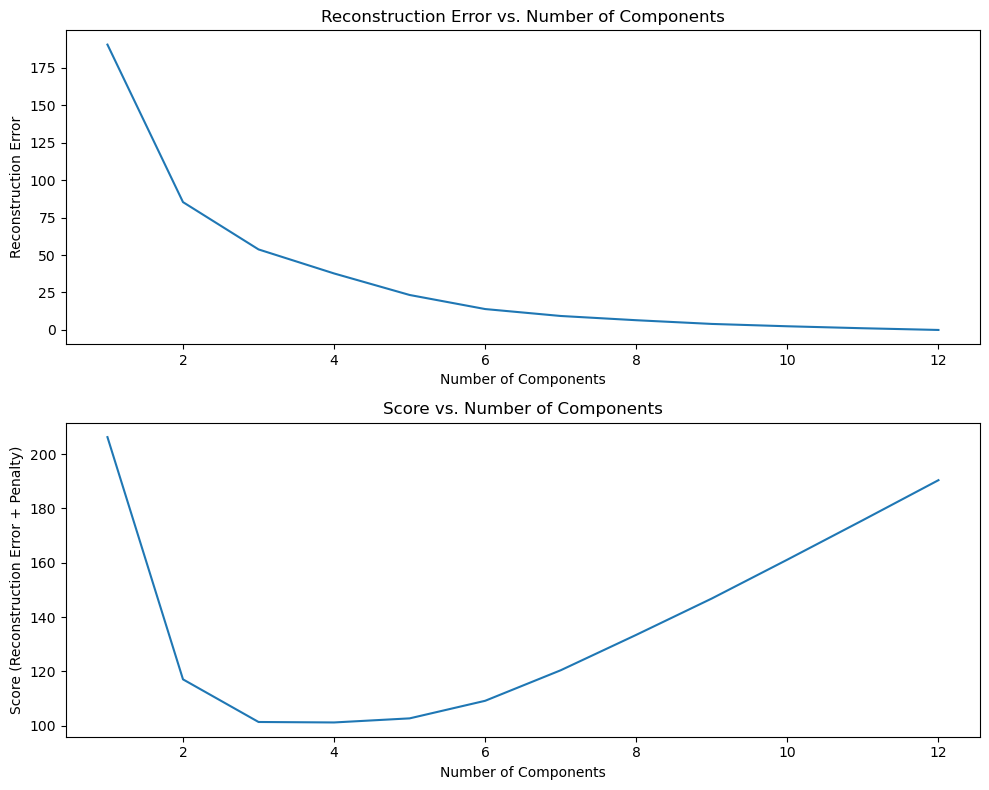

Optimal number of components: 4


In [39]:
optimal_n_components = find_optimal_n_components(chroma_sync.T, plot_reconstruction_error=True)

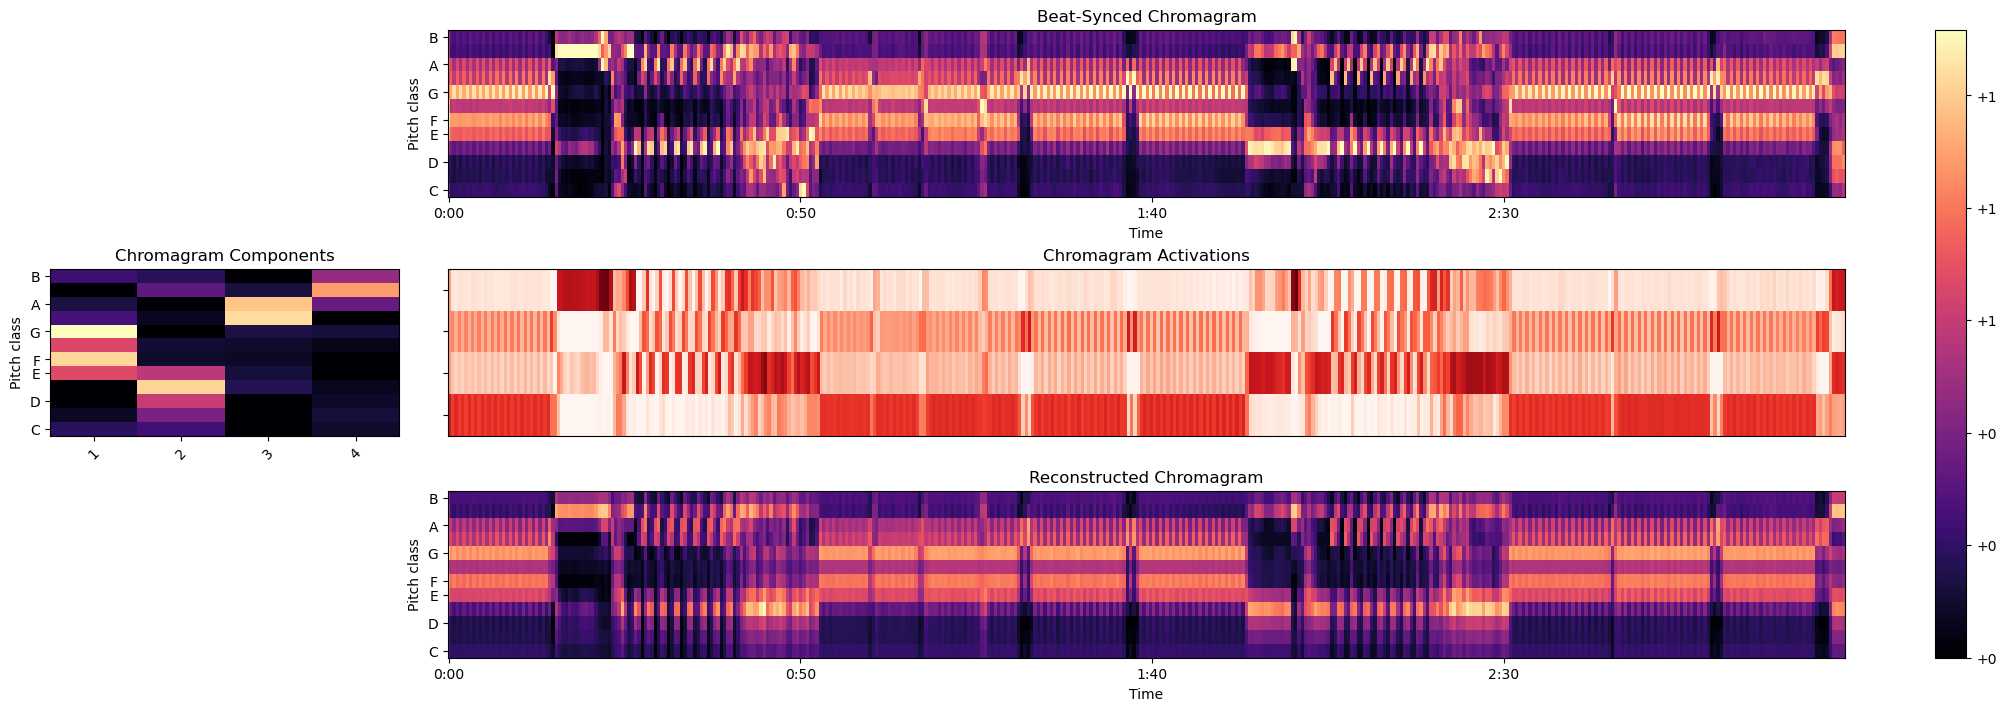

In [40]:
chroma_comps = (nmf.components_).T

# Define the layout for subplots
layout = [
    ['.', 'A', 'A', 'A', 'A'],
    ['B', 'C', 'C', 'C', 'C'],
    ['.', 'D', 'D', 'D', 'D']
]

# Create the subplots with specified figure size
fig, ax = plt.subplot_mosaic(layout, figsize=(20, 7), constrained_layout=True)

# Display the original chroma_sync
librosa.display.specshow(chroma_sync, y_axis='chroma', x_axis='time', ax=ax['A'],
                         sr=sr, hop_length=hop_length, x_coords=beat_grid_times)
ax['A'].set(title='Beat-Synced Chromagram')

# Display the components
librosa.display.specshow(chroma_comps, y_axis='chroma', ax=ax['B'], sr=sr, hop_length=hop_length)
ax['B'].set(title='Chromagram Components')
# Set custom x-tick labels to denote component numbers
ax['B'].set_xticks(np.arange(chroma_comps.shape[1]))
ax['B'].set_xticklabels([f"{i+1}" for i in range(chroma_comps.shape[1])])
ax['B'].tick_params(axis='x', rotation=45)

# Display the activations with a red color map
librosa.display.specshow(chroma_acts, ax=ax['C'], cmap='Reds', x_coords=np.arange(chroma_acts.shape[1]))
ax['C'].set(ylabel='Component number', title='Chromagram Activations')
# Set custom y-tick labels to denote component numbers
ax['C'].set_yticks(np.arange(chroma_acts.shape[0]))
ax['C'].set_yticklabels([f"{i+1}" for i in range(chroma_acts.shape[0])])
ax['C'].label_outer()

# Reconstruct the chroma_sync from the components and activations
chroma_sync_approx = chroma_comps @ chroma_acts

# Display the reconstructed chroma_sync
img = librosa.display.specshow(chroma_sync_approx, y_axis='chroma', x_axis='time', ax=ax['D'],
                               sr=sr, hop_length=hop_length, x_coords=beat_grid_times)
ax['D'].set(title='Reconstructed Chromagram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])

# Add a colorbar to the figure
fig.colorbar(img, ax=list(ax.values()), format="%+2.f")

# Show the plot
plt.show()

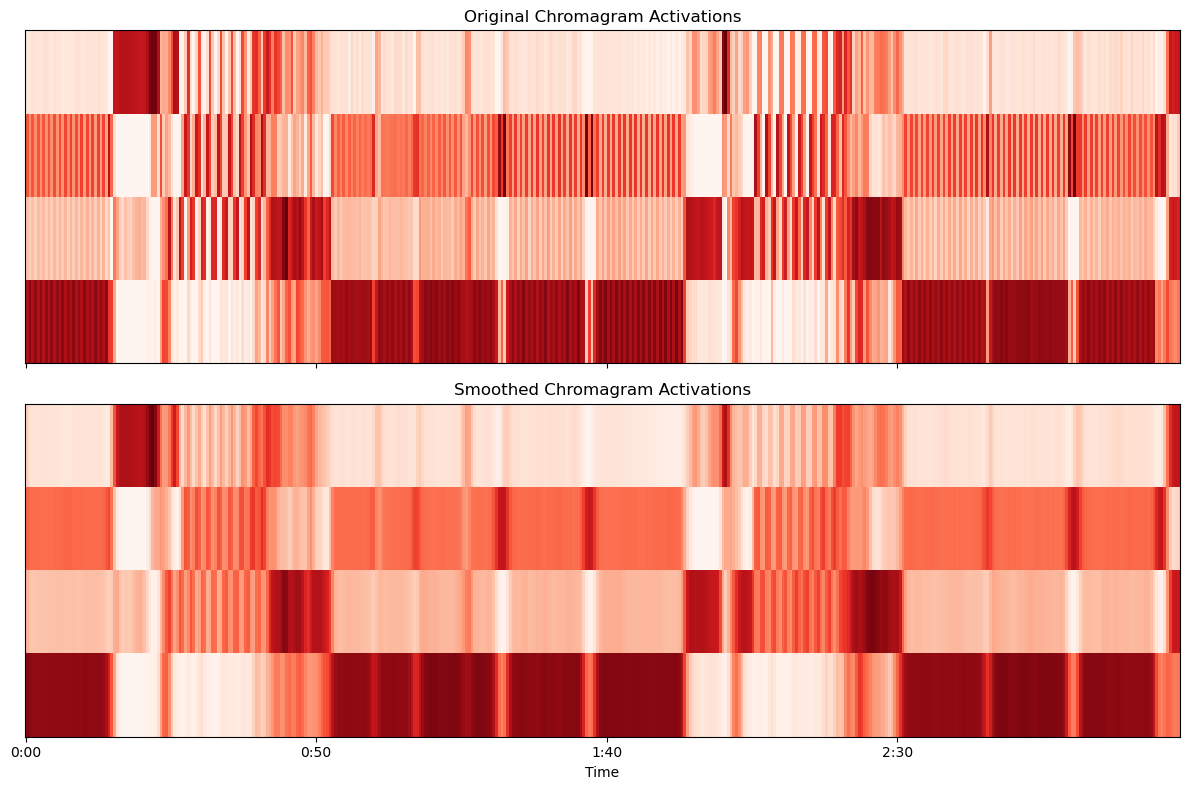

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the original activations
librosa.display.specshow(chroma_acts, x_axis='time', ax=ax1, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='Reds')
ax1.set_title('Original Chromagram Activations')
ax1.label_outer()

# Plot the smoothed activations
librosa.display.specshow(chroma_acts_smooth, x_axis='time', ax=ax2, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='Reds')
ax2.set_title('Smoothed Chromagram Activations')
ax2.label_outer()

plt.tight_layout()
plt.show()

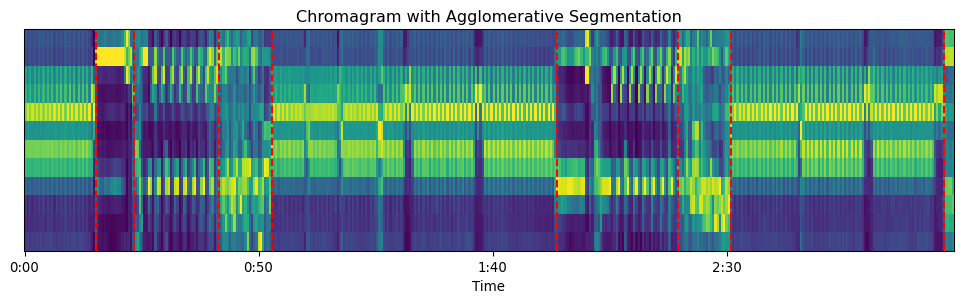

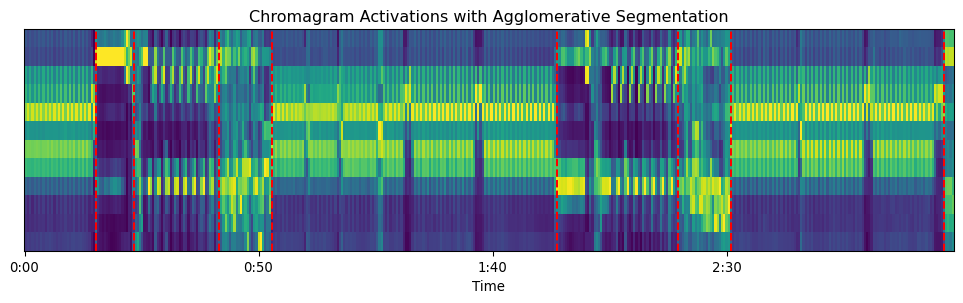

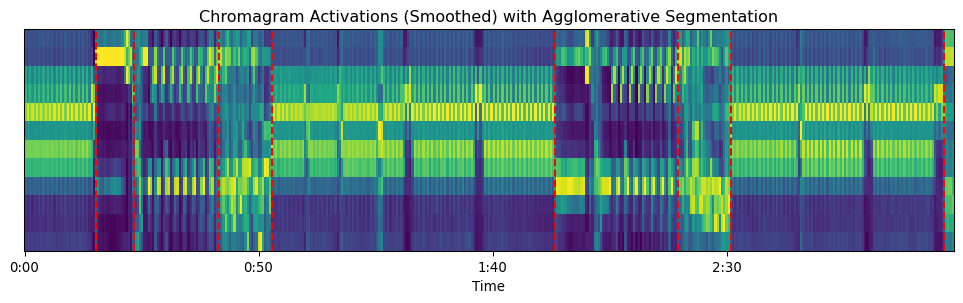

In [42]:
fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)
librosa.display.specshow(chroma_sync, x_axis='time', ax=ax, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='viridis')
for time in bound_times:
    ax.axvline(time, 0, chroma_sync.shape[0], color='r', linestyle='--', label='Segment Boundary')
ax.set_title('Chromagram with Agglomerative Segmentation')
plt.show()

fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)
librosa.display.specshow(chroma_sync, x_axis='time', ax=ax, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='viridis')
for time in bound_times_norm:
    ax.axvline(time, 0, chroma_sync.shape[0], color='r', linestyle='--', label='Segment Boundary')
ax.set_title('Chromagram Activations with Agglomerative Segmentation')
plt.show()

fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)
librosa.display.specshow(chroma_sync, x_axis='time', ax=ax, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='viridis')
for time in bound_times_smooth:
    ax.axvline(time, 0, chroma_sync.shape[0], color='r', linestyle='--', label='Segment Boundary')
ax.set_title('Chromagram Activations (Smoothed) with Agglomerative Segmentation')
plt.show()

In [123]:
# Constants
hop_length = 128 
sr = 12000
df = pd.read_csv('../data/clean_labeled.csv') 
segment_data = []

progress_bar = tqdm(df["SongID"].unique(), desc="Processing songs", unit="song", leave=True)
for song_id in progress_bar:
    # Load audio and extract features
    audio_file = f'../data/audio_files/processed/{song_id}.mp3'
    y, _ = librosa.load(audio_file, sr=sr)
    y_harm, y_perc = librosa.effects.hpss(y)
    onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
    duration = librosa.get_duration(y=y_perc, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    beat_grid_frames = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='frames')
    beat_grid_times = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='time')

    # Extract segmentation bounds for normal chromagram
    chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chroma_sync = librosa.util.sync(chromagram, beat_grid_frames, aggregate=np.mean)
    chroma_sync = MinMaxScaler().fit_transform(chroma_sync.T).T
    optimal_n_components = find_optimal_n_components(chroma_sync.T, plot_reconstruction_error=False)
    nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
    chroma_acts = nmf.fit_transform(chroma_sync.T).T
    chroma_acts = (chroma_acts - chroma_acts.min(axis=1, keepdims=True)) / (chroma_acts.max(axis=1, keepdims=True) - chroma_acts.min(axis=1, keepdims=True))
    chroma_acts_smooth = gaussian_filter1d(chroma_acts, sigma=1, axis=1)
    bounds_chroma = librosa.segment.agglomerative(chroma_sync, 9)
    bounds_chroma_acts = librosa.segment.agglomerative(chroma_acts, 9)
    bounds_chroma_acts_smooth = librosa.segment.agglomerative(chroma_acts_smooth, 9)

    # Extract segmentation bounds for key-invariant chromagram
    ki_chromagram = calculate_ki_chroma(y_harm, sr=sr, hop_length=hop_length)
    ki_chroma_sync = librosa.util.sync(ki_chromagram, beat_grid_frames, aggregate=np.mean)
    ki_chroma_sync = MinMaxScaler().fit_transform(ki_chroma_sync.T).T
    ki_optimal_n_components = find_optimal_n_components(ki_chroma_sync.T, plot_reconstruction_error=False)
    ki_nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
    ki_chroma_acts = ki_nmf.fit_transform(ki_chroma_sync.T).T
    ki_chroma_acts = (ki_chroma_acts - ki_chroma_acts.min(axis=1, keepdims=True)) / (ki_chroma_acts.max(axis=1, keepdims=True) - ki_chroma_acts.min(axis=1, keepdims=True))
    ki_chroma_acts_smooth = gaussian_filter1d(ki_chroma_acts, sigma=1, axis=1)
    ki_bounds_chroma = librosa.segment.agglomerative(ki_chroma_sync, 9)
    ki_bounds_chroma_acts = librosa.segment.agglomerative(ki_chroma_acts, 9)
    ki_bounds_chroma_acts_smooth = librosa.segment.agglomerative(ki_chroma_acts_smooth, 9)

    # Extract bound times
    bound_times_chroma = process_bound_times(bounds_chroma, beat_grid_times, duration)
    bound_times_chroma_acts = process_bound_times(bounds_chroma_acts, beat_grid_times, duration)
    bound_times_chroma_acts_smooth = process_bound_times(bounds_chroma_acts_smooth, beat_grid_times, duration)
    ki_bound_times_chroma = process_bound_times(ki_bounds_chroma, beat_grid_times, duration)
    ki_bound_times_chroma_acts = process_bound_times(ki_bounds_chroma_acts, beat_grid_times, duration)
    ki_bound_times_chroma_acts_smooth = process_bound_times(ki_bounds_chroma_acts_smooth, beat_grid_times, duration)

    # Create segments for each bound type
    all_bound_times = [bound_times_chroma, bound_times_chroma_acts, 
                       bound_times_chroma_acts_smooth, ki_bound_times_chroma,
                       ki_bound_times_chroma_acts, ki_bound_times_chroma_acts_smooth]

    for bound_times, seg_type in zip(all_bound_times, ['chromagram', 'chroma_acts', 'chroma_acts_smoothed',
                                                       'ki_chroma', 'ki_chroma_acts', 'ki_chroma_acts_smoothed']):
        segment_num = 1
        for start, end in zip(bound_times[:-1], bound_times[1:]):
            start_beat_idx = np.argmin(np.abs(np.array(beat_grid_times) - start))
            end_beat_idx = np.argmin(np.abs(np.array(beat_grid_times) - end))
            num_beats = end_beat_idx - start_beat_idx
            seg_duration = end - start
            segment_data.append({
                'SongID': song_id,
                'segment_num': segment_num,
                'segment_start': start,
                'segment_end': end,
                'duration': seg_duration,
                'start_beat_idx': start_beat_idx,
                'end_beat_idx': end_beat_idx,
                'num_beats': num_beats,
                'seg_type': seg_type
            })
            segment_num += 1

segment_df = pd.DataFrame(segment_data)
segment_df.to_csv('../data/agglomerative_segmentation_results.csv', index=False)

Processing songs:   0%|          | 0/332 [00:00<?, ?song/s]